# Analisis de Datos Faltantes sobre un Dataset de Boyas Oceanicas

In [1]:
# Librerias
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
#import session_info
import upsetplot

In [2]:
# linea para correr el notebook utils
%run utils.ipynb

## Cargar el conjunto de Datos desde una Web

In [3]:
# Guardar la url en una variable
datos_url = 'https://github.com/njtierney/naniar/raw/master/data/'

# Almacenar los nombres de los archivos a descargar en una lista
datasets_names = ('oceanbuoys', 'pedestrian', 'riskfactors')

# Almacenar el tipo de extension en una variable
extension = '.rda'

# diccionario que almacena los archivos descargados
datasets_dfs = {} 

for dataset_name in datasets_names:

    dataset_file = f'{ dataset_name }{ extension }' # almacena el nombre de cada archivo con su respectiva extension
    dataset_output_file = f'./data/{ dataset_file }' # ruta y nombre donde se guarda los archivos
    dataset_url = f'{ datos_url }{ dataset_file }' # url de cada archivo a descargar

    !wget -q -O { dataset_output_file } { dataset_url } # linea que descarga los archivos

    # almacenar en el diccionario los archivos descargados
    datasets_dfs[f'{ dataset_name }_df'] = pyreadr.read_r(dataset_output_file).get(dataset_name)

# accede a las llaves del diccionario para verificar que los archivos se hayan cargado
datasets_dfs.keys()

dict_keys(['oceanbuoys_df', 'pedestrian_df', 'riskfactors_df'])

### Incluir el conjunto de datos en nuestro ambiente local

In [4]:
locals().update(**datasets_dfs)
# elimina el diccionario para dejar solamente los dataframes
del datasets_dfs

In [5]:
# carga del dataframe
oceanbuoys_df.shape

(736, 8)

## Configuracion de las Graficas

In [6]:
%matplotlib inline

# tamaño de los graficos
sns.set(
    rc={
        'figure.figsize':(8, 8)
    }
)

# estilo de los graficos
sns.set_style('whitegrid')

## EDA de los datos

In [7]:
oceanbuoys_df

,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns
0,1997.0,0.0,-110.0,27.590000,27.150000,79.599998,-6.4,5.4
1,1997.0,0.0,-110.0,27.549999,27.020000,75.800003,-5.3,5.3
2,1997.0,0.0,-110.0,27.570000,27.000000,76.500000,-5.1,4.5
3,1997.0,0.0,-110.0,27.620001,26.930000,76.199997,-4.9,2.5
4,1997.0,0.0,-110.0,27.650000,26.840000,76.400002,-3.5,4.1
...,...,...,...,...,...,...,...,...
731,1993.0,-2.0,-110.0,24.780001,24.620001,90.800003,-4.4,1.7
732,1993.0,-2.0,-110.0,24.879999,24.500000,91.099998,-3.0,0.2
733,1993.0,-2.0,-110.0,25.120001,24.889999,89.699997,-4.0,1.1
734,1993.0,-2.0,-110.0,25.160000,24.930000,89.500000,-4.3,2.5


In [8]:
# Tipos de datos
oceanbuoys_df.dtypes

year          float64
latitude      float64
longitude     float64
sea_temp_c    float64
air_temp_c    float64
humidity      float64
wind_ew       float64
wind_ns       float64
dtype: object

Todas las variables son de tipo numerica flotante.

In [9]:
# variables que contienen valores nulos
(
    oceanbuoys_df
    .isna()
    .any()
)

year          False
latitude      False
longitude     False
sea_temp_c     True
air_temp_c     True
humidity       True
wind_ew       False
wind_ns       False
dtype: bool

Los valores nulos se concentran en las variables sea_temp_c, air_temp_c y humidity.

In [10]:
# Cantidad de valores nulos por variable
(
    oceanbuoys_df
    .isnull()
    .sum()
)

year           0
latitude       0
longitude      0
sea_temp_c     3
air_temp_c    81
humidity      93
wind_ew        0
wind_ns        0
dtype: int64

La mayor cantidad de valores nulos se concentran en air_temp_c y Humidity. Puede que haya alguna relacion entre estas variables.

In [11]:
# numero total de valores nulos
(
    oceanbuoys_df
    .isnull()
    .sum()
    .sum()
)

177

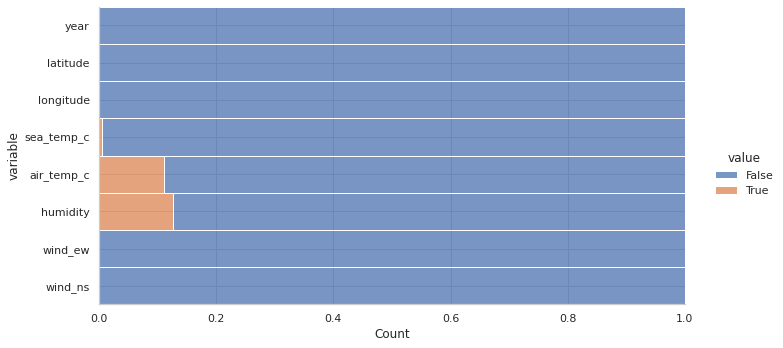

In [12]:
# Visualizacion de la proporcion de valores nulos por cada variable
(
    oceanbuoys_df
    .isnull()
    .melt()
    .pipe(
        lambda df:(
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2
            )
        )
    )
)
plt.show()

In [13]:
# Numero de observaciones perdidas si se eliminan los valores faltantes
proof_oceanbuoys_df = (
    oceanbuoys_df
    .dropna()
)
proof_oceanbuoys_df.shape

(565, 8)

In [14]:
# numero de observaciones en el DF
oceanbuoys_df.shape

(736, 8)

In [15]:
# numero de observaciones eliminadas
736 - 565

171

In [16]:
# porcentaje que representa el numero de observaciones eliminadas
pct_of = 100 - (565/736)*100
pct_of

23.233695652173907

El dataframe contiene 736 observaciones. Si se eliminan los registros con valores faltantes quedan un total de 565 observaciones, es decir, se sacrifican mas de 171 observaciones que corresponden al 23% del total en el dataframe. Esto indica que no es recomendable utilizar el Metodo de eliminacion por lista para el tratamiento de valores faltantes ya que se pierde mucha informacion. 

### Resumen Estadistico de las variables

In [17]:
oceanbuoys_df.describe()

,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns
count,736.00000,736.000000,736.0000,733.000000,655.000000,643.000000,736.000000,736.000000
mean,1995.00000,-1.375000,-102.5000,25.864952,25.029252,84.434992,-3.715897,2.635734
std,2.00136,1.654719,7.5051,2.448436,2.000025,4.589332,1.958802,2.109857
min,1993.00000,-5.000000,-110.0000,21.600000,21.420000,71.599998,-8.100000,-6.200000
25%,1993.00000,-2.000000,-110.0000,23.500000,23.260000,81.300003,-5.100000,1.500000
50%,1995.00000,-1.000000,-102.5000,26.549999,24.520000,85.199997,-3.900000,2.900000
75%,1997.00000,0.000000,-95.0000,28.209999,27.080000,88.099998,-2.600000,4.100000
max,1997.00000,0.000000,-95.0000,30.170000,28.500000,94.800003,4.300000,7.300000


## Analisis Basico de Valores Faltantes sobre el DF

### Calculo del Porcentaje de valores faltantes

In [18]:
# cantidad de datos
total = 736*8
total

5888

In [19]:
# cantidad de valores completos
v_complet = oceanbuoys_df.missing.number_complete()
v_complet

5711

In [20]:
# cantidad de valores faltantes
v_mising = oceanbuoys_df.missing.number_missing()
v_mising

177

In [21]:
# Porcentaje de valores faltantes en el DF
pct_v = (v_mising/v_complet)*100
pct_v

3.09928208720014

Alrededor del 3% de los datos corresponden a valores faltantes. Aunque no representa un numero amplio, vamos a aplicar todo el analisis requerido.

### Estadistica de las variables segun los datos faltantes 

In [22]:
# estadistica de cada variable segun sus valores faltantes
oceanbuoys_df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,year,0,736,0.000000
1,latitude,0,736,0.000000
2,longitude,0,736,0.000000
3,sea_temp_c,3,736,0.407609
4,air_temp_c,81,736,11.005435
5,humidity,93,736,12.635870
6,wind_ew,0,736,0.000000
7,wind_ns,0,736,0.000000


En el resumen vemos que tanto air_temp_c como humidity son las variables con mayor cantidad de valores faltantes teniendo un 11% la primera y un 12.6% la segunda variable.

### Estadistica de valores faltantes segun el numero de variables

In [23]:
# estadistica de valores faltantes en funcion de las variables presentados en una Tabla
oceanbuoys_df.missing.missing_variable_table()

,n_missing_in_variable,n_variables,pct_variables
0,0,5,62.5
1,3,1,12.5
2,81,1,12.5
3,93,1,12.5


La tabla indica que hay 5 variables que no tienen valores faltantes, 1 con solo 3 missing, 1 con 81 missing y 1 con 93 missing para un total de 8 variables.

### Estadistica de valores faltantes para cada registro

In [24]:
# cantidad de valores faltantes para cada registro
oceanbuoys_df.missing.missing_case_summary()

,case,n_missing,pct_missing
0,0,0,0.0
1,1,0,0.0
2,2,0,0.0
3,3,0,0.0
4,4,0,0.0
...,...,...,...
731,731,0,0.0
732,732,0,0.0
733,733,0,0.0
734,734,0,0.0


### Estadistica tabulada de Registros con su correspondiente cantidad de valores faltantes

In [25]:
# registros con su correpondiente cantidad de valores faltantes
oceanbuoys_df.missing.missing_case_table()

,n_missing_in_case,n_cases,pct_case
0,0,565,76.766304
1,1,167,22.690217
2,2,2,0.271739
3,3,2,0.271739


la tabla indica que hay 565 registros que no poseen missing, 167 con solo 1 missing, 2 con 2 missing y 2 con solo 3 missing.

### Estadisticas de valores faltantes por intervalos de registros para una variable

In [26]:
# estadistica de valores faltantes para intervalos de 10 registros de la variable humidity
oceanbuoys_df.missing.missing_variable_span(variable='humidity',span_every=50)

,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,0,50,0.0,100.0
1,1,0,50,0.0,100.0
2,2,0,50,0.0,100.0
3,3,0,50,0.0,100.0
4,4,0,50,0.0,100.0
5,5,0,50,0.0,100.0
6,6,0,50,0.0,100.0
7,7,0,50,0.0,100.0
8,8,0,50,0.0,100.0
9,9,41,9,82.0,18.0


La tabla anterior indica que el 82% de los datos de la variable humidity en el intervalo de 450 a 500 son valores faltantes. Mientras que todos los datos del intervalo que va de 500 a 550 son valores faltantes. De esta manera podemos apreciar los intervalos donde se concentran los missing.

### Estadistica de intervalos consecutivos con valores faltantes y completos para una variable

In [27]:
# estadistica de intervalos consecutivos con valores faltantes y 
# completos para la variable humidity
oceanbuoys_df.missing.missing_variable_run(variable='humidity')

,run_length,is_na
0,459,complete
1,93,missing
2,184,complete


La tabla indica que los primeros 459 registros de la variable humidity estan completos, los siguientes 93 registros possen missing y los restantes estan completos. Esto quiere decir que los missing de la variable estan concentrados en una zona particular lo que indica que no son missin aleatorios.

## Visualizacion de Valores Faltantes

### Visualizacion mediante un grafico de Paleta

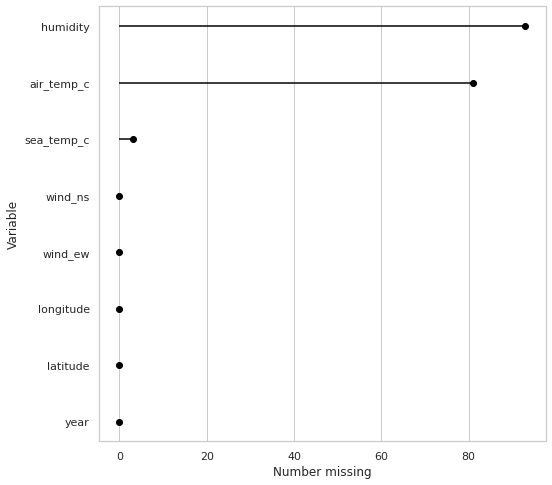

In [28]:
oceanbuoys_df.missing.missing_variable_plot()

La grafica ratifica que la variable con mayor numero de valores faltantes es humidity seguido de la variable air_temp_c

### Histograma de observaciones con datos faltantes

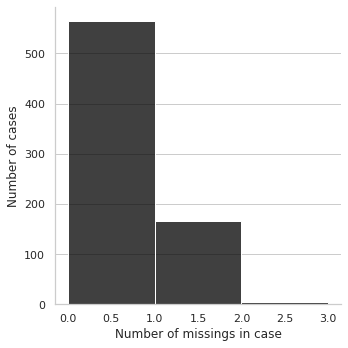

In [29]:
oceanbuoys_df.missing.missing_case_plot()

La grafica indica que hay mas de 500 observaciones con 1 solo missing y mas de 150 observaciones con 2 missing.

### Visualizacion de valores faltantes en una variable por rangos consecutivos

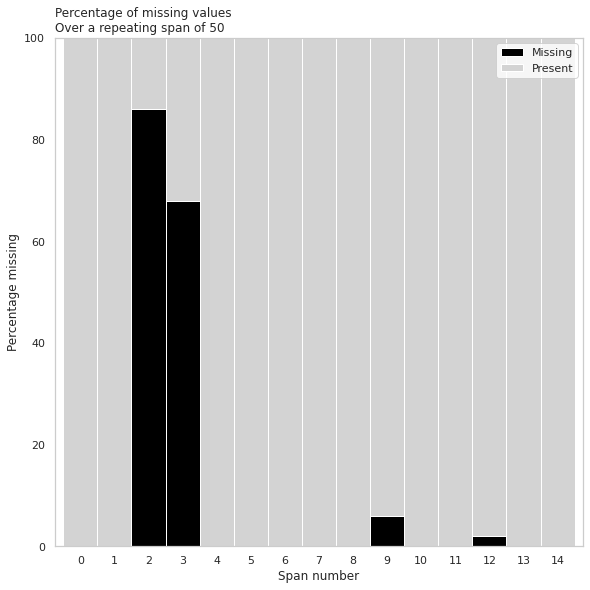

In [31]:
# visualizacion de valores faltantes para la variable air_temp_c en rangos de 50
(
    oceanbuoys_df
    .missing
    .missing_variable_span_plot(
        variable='air_temp_c', # variable a analizar
        span_every=50, # rango
        rot=0 # rotacion de las etiquetas
    )
)

Podemos concluir que mas del 80% de los datos del rango que va de 100 a 149 son datos faltantes. Tambien mas del 60% de los datos del rango que va de 150 a 199 son valores faltantes. Esto indica que para la variable air_temp_c los valores faltantes no son aleatorio sino que sigue cierto patron.